In [0]:
# Common imports
from pathlib import Path
import os
import numpy as np

In [0]:
# Standard block to equalize local and Colab.
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    !pip install -q tensorflow-gpu==2.0.0-alpha0
    import tensorflow as tf
    # Configure kaggle
    files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
    !pip install -q kaggle
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    # Download the workshop repo and change to its directory
    # For now edit the username/password. This requirement will be removed when the repo is made public.
    !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git ../repo
    os.chdir('../repo')
    !pip install tensorboardcolab
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
    tbc=TensorBoardColab(startup_waiting_time=30)
    tensorboard_callback = TensorBoardColabCallback(tbc)
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Add Python env Scripts to path for kaggle use.
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    # Clear any logs from previous runs
    if (Path.cwd() / 'logs').is_dir():
        !rmdir /S /Q logs
    import tensorflow as tf
    import datetime
    %load_ext tensorboard.notebook
    log_dir = Path.cwd() / "logs" / datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    IN_COLAB = False

Saving kaggle.json to kaggle.json
Cloning into '../repo'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 323 (delta 116), reused 136 (delta 73), pack-reused 121
Receiving objects: 100% (323/323), 2.44 MiB | 2.10 MiB/s, done.
Resolving deltas: 100% (162/162), done.


Using TensorFlow backend.


Wait for 30 seconds...


## Get Data
Download faces_basic if we don't already have it.
If you get 401 - Unauthorized, then Chad needs to add your kaggle account,
or you need to create a new API token from kaggle

In [0]:
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d cboulay/kjm-ecog-faces-basic
    print("Finished downloading. Now extracting contents...")
    data_path = Path('kjm-ecog-faces-basic.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir / 'converted' / 'faces_basic')
    data_path.unlink()

In [0]:
# Load data from one participant.
SUB_ID = 'de'
from data.utils.fileio import from_neuropype_h5
test_file = datadir / 'converted' / 'faces_basic' / (SUB_ID + '_bp.h5')
chunks = from_neuropype_h5(test_file)
chunk_names = [_[0] for _ in chunks]
chunk = chunks[chunk_names.index('signals')][1]
ax_types = [_['type'] for _ in chunk['axes']]
instance_axis = chunk['axes'][ax_types.index('instance')]
n_trials = len(instance_axis['data'])
X = chunk['data'].reshape((n_trials, -1))  # 603 trials x 527 features
Y = instance_axis['data']['Marker'].values.reshape(-1, 1)
n_trials, n_features = X.shape
print(X.shape, Y.shape)

(603, 527) (603, 1)


## Creating an artificial neural net with Tensorflow and Keras

We will next create a "model". The model maps the input data to some output.

Each trial _idx_ in our input has our brain signal data X[idx] and a label Y[idx].

Each data point in X[idx] is of shape (n_features,),
where n_features is the product m_channels * n_samples.

Each label (Y[idx]) is 1 of 3 values: "ISI", "face", or "house".

So we want to find a model that maps from an n_features input to 3 outputs,
where each of the outputs is a score associated with a class.
We will use a simple linear fully-connected model with a single layer.
I honestly couldn't think of a simpler neural network.

![simple linear network](https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/img/simple_linear_nn.png?raw=1)
created with [NN-SVG](http://alexlenail.me/NN-SVG/index.html)

We use Tensorflow to create and train the model.
The model specification is done using the [Keras API, as provided by tensorflow](https://www.tensorflow.org/guide/keras).

Tensorflow has ["eager execution"](https://www.tensorflow.org/guide/eager)
enabled so TensorFlow operations execute immediately and their results can be inspected.
This is the default behaviour in upcoming TensorFlow 2.0 so we might as well get used to it.
[Another tf.eager tutorial here.](https://adventuresinmachinelearning.com/tensorflow-eager-tutorial/)



In [0]:
# Create the model. Use functional interface.
inputs = tf.keras.layers.Input(shape=(X.shape[1],))
dat_in_model = tf.keras.layers.Dense(3, activation='linear')(inputs)
outputs = tf.keras.layers.Softmax()(dat_in_model)  # Convert to probability scores, summing to 1
model = tf.keras.Model(inputs, outputs)

# Note: The Dense layer can use an activation='softmax' and we could drop the Softmax layer.

Before the network is ready, it needs three more things:
* A loss function. See options in tf.losses
* An optimizer. See options in tf.keras.optimizers ('Adam', 'rmsprop', 'SGD')
* Metrics to monitor during training

[neat graph for optimizers](https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough#create_an_optimizer)

These are configured during compilation

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 527)]             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1584      
_________________________________________________________________
softmax (Softmax)            (None, 3)                 0         
Total params: 1,584
Trainable params: 1,584
Non-trainable params: 0
_________________________________________________________________


## Prepare data to feed into the model

### Create the dataset
Tensorflow has a data API called [tf.data](https://www.tensorflow.org/guide/datasets).
We will use it to create a [`Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

Note that we use Eager so the Dataset usage is maybe different to what you will find in other Dataset
tutorials. The differences are [explained here](https://www.tensorflow.org/tutorials/eager/eager_basics#datasets).

Datasets provide several important features:
* implicit conversion from other types to tensorflow Tensor types
* easy transformations
* automatic feeding of data into hungry models

See a more complete example [here](https://gist.github.com/datlife/abfe263803691a8864b7a2d4f87c4ab8).


In [0]:
# Convert Y from strings to integers.
classes, y = np.unique(Y, return_inverse=True)
n_classes = len(classes)
n_trials = len(y)

### Organize data for training and validation.
Let's use 80% of the data for training and the remaining for validation.

Note: It is good practice to separate data into 3 sets: training, validation, and test.
Otherwise, the hyperparameter tuning to improve performance on the validation set will leak
information about the validation set into the model, so the model training is no longer blind to the
validation set and performance on the validation set is not indicative of real world performance.
However, today we are not concerned with real-world performance, so we don't want to hinder ourselves
by limiting the amount of training data we have.

Before we start slicing up our data, it's useful to put the neural data (X) and labels (Y)
into a single container. For that we use [tf.data.Datset.zip](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip), which is implied by passing a tuple of data items to `from_tensor_slices`.

Finally, we separate into training and validation sets.

In [0]:
from sklearn.model_selection import train_test_split
PTRAIN = 0.8
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=PTRAIN)
n_train = len(y_train)
n_valid = len(y_valid)
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

### Apply transformations to the dataset

We define a function to separately transform X and y.

First we downcast X from float64 to float32.

y is a set of integers from 0-2 representing the id of the class for each trial.
There is no reasoning that the distance between 0 (ISI) and 1 (face) is the same
as the distance between 1 (face) and 2 (house). We cannot train a model to think
that house-related activity is twice as face-y as face-related activity.
In other words, Y is not a continuous variable. It is a categorical variable.

One way to represent a non-binary categorical variable is to use one-hot encoding:
[0, 1, 2, 1] becomes [[1, 0, 0], [0, 1, 0], [0, 0, 1], [0, 1, 0]].


In [0]:
def preprocess_fn(x_dat, y_dat):
    x_dat = tf.cast(x_dat, tf.float32)
    y_dat = tf.one_hot(tf.cast(y_dat, tf.uint8), n_classes)
    return x_dat, y_dat
ds_train = ds_train.map(preprocess_fn)
ds_valid = ds_valid.map(preprocess_fn)

### Further transform the data to prepare for training
When training a neural net, we can update the model using only a single trial at a time,
or we can update the model using a batch of trials. Let's tell our training data that we
want it to be fed into the model in batches, using [dataset.batch(BATCH_SIZE)](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch).
Having larger batches speeds up training but requires more memory. You can try increasing
BATCH_SIZE (then try training) until you run out of GPU memory.
The downside to having a larger BATCH_SIZE is that there is less granularity during training. 

We also [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the training trials.

In [0]:
BATCH_SIZE = 5
ds_train = ds_train.shuffle(int(n_trials * PTRAIN) + 1).batch(BATCH_SIZE, drop_remainder=True).repeat()  # , drop_remainder=True?
ds_valid = ds_valid.batch(BATCH_SIZE).repeat()

## Train the model

Typically we will go through the dataset more than once.
Each trip through the entire training dataset is called an 'epoch'.
How many epochs do we want? Typically you want as many epochs as you need to maximize performance
on the validation set. Too many can lead to over-fitting on the training set.
We should also be concerned about training time, energy usage, etc.


In [0]:
N_EPOCHS = 10
history = model.fit(x=ds_train,  
                    epochs=N_EPOCHS, 
                    validation_data=ds_valid,
                    steps_per_epoch=n_train // BATCH_SIZE,
                    validation_steps=(len(Y)-n_train) // BATCH_SIZE,
                    callbacks=[tensorboard_callback],
                    verbose=1)

Epoch 1/10
 1/96 [..............................] - ETA: 1:02 - loss: 0.9056 - accuracy: 0.6000

W0522 16:52:47.054240  5848 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.141521). Check your callbacks.


 2/96 [..............................] - ETA: 39s - loss: 1.0458 - accuracy: 0.5000 

W0522 16:52:47.063243  5848 callbacks.py:236] Method (on_train_batch_end) is slow compared to the batch update (0.114999). Check your callbacks.


96/96 [==============================] - ETA: 4s - loss: 0.8328 - accuracy: 0.712 - ETA: 2s - loss: 0.7499 - accuracy: 0.71 - ETA: 1s - loss: 0.6903 - accuracy: 0.72 - ETA: 0s - loss: 0.6441 - accuracy: 0.73 - ETA: 0s - loss: 0.6065 - accuracy: 0.76 - ETA: 0s - loss: 0.5573 - accuracy: 0.78 - 2s 17ms/step - loss: 0.5401 - accuracy: 0.7875 - val_loss: 0.3026 - val_accuracy: 0.8667
Epoch 2/10
96/96 [==============================] - ETA: 2s - loss: 0.1833 - accuracy: 1.00 - ETA: 0s - loss: 0.2333 - accuracy: 0.92 - ETA: 0s - loss: 0.2033 - accuracy: 0.95 - ETA: 0s - loss: 0.1831 - accuracy: 0.96 - ETA: 0s - loss: 0.1881 - accuracy: 0.95 - ETA: 0s - loss: 0.1733 - accuracy: 0.95 - ETA: 0s - loss: 0.1684 - accuracy: 0.95 - 1s 7ms/step - loss: 0.1668 - accuracy: 0.9583 - val_loss: 0.1529 - val_accuracy: 0.9583
Epoch 3/10
96/96 [==============================] - ETA: 2s - loss: 0.0393 - accuracy: 1.00 - ETA: 0s - loss: 0.0843 - accuracy: 0.98 - ETA: 0s - loss: 0.0812 - accuracy: 0.98 - ETA: 

In [0]:
if not IN_COLAB:
    tb_dir = 'logs/' + str(log_dir.stem)
    print(tb_dir)
    %tensorboard --logdir={tb_dir}

logs/20190522-165216


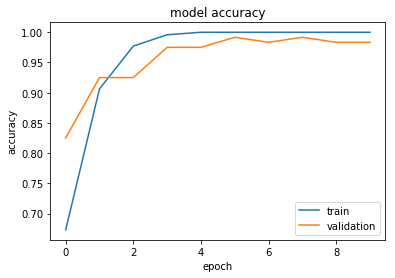

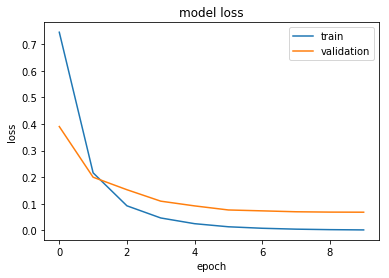

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Inspecting the model
TODO: visualize the weights like with did for LDA

## Exercises

### Choose a different participant
The participant data that we've been using so far is easily classified,
which is nice to confirm things work, but is not very useful when trying
to understand how to improve.

Go back to the cell above where the participant data are imported
and replace 'de' with 'rn'
### Try a different activation function
Chaining linear activations doesn't get you much, because
chaining linear matrix transformations yields a single matrix.
We need something non-linear happening before we can benefit from
adding more layers.
### Try adding more layers

  